<a href="https://colab.research.google.com/github/EduHdzVillasana/COVIDSTATSMX/blob/master/An%C3%A1lisis%20y%20Modelado/COVID_MX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis estadístico del dataset de COVID-19 proporcionado por la secretaría de salud.

### Objetivos
* Identidicar los factores de los pacientes que aumentan su probabilidad de fallecer o presentar enfermedad grave.
* Identificar si la mortalidad varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si la probabilidad de padecer la enfermedad grave varía dependiendo de la recidencia del paciente o en qué institución de salud se atendió.
* Identificar si los dias entre el inicio de los sintomas y la atención médica afecta en la mortalidad.
* Conocer si la mortalidad y la positividad cambió en el transcurso de la pandemia.
* Realizar una limpieza y tratamiento de datos para obtener un dataset listo para crear un modelo predictorio de la probabilidad de muerte de un paciente dadas sus características.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import os
import sys
import seaborn as sns

# Librerias para la regresión logística
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate
from sklearn import linear_model

# Librerias para la validación del modelo
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Librería hecha para manejar el dataset de covid
#sys.path.insert(1,'/content/drive/MyDrive/Python Scripts/')
sys.path.insert(1,'../Proyecto en Twitter/')
import COVID19_MX as covid

## Carga de Dataset principal y auxiliares
Los dataset auxiliares `sexo_df`, `sector_df` y `entidad_df` servirán para usar variables categóricas en el modelo.

In [3]:
#aux_dataset_path = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Diccionario%20de%20Datos"
#main_dataset_path = "/content/drive/MyDrive/Datos Abiertos"

aux_dataset_path = "C:/Users/alana/Documents/GitHub/COVIDSTATSMX/Diccionario de Datos"
main_dataset_path = "C:/Users/alana/Documents/COVIDSTATSMX/Datos Abiertos"
covid_file = "210811COVID19MEXICO.csv"
sexo_file = "Sexo.csv"
sector_file = "Sector.csv"
entidad_file = "Entidad.csv"

In [4]:
covid_df = pd.read_csv(os.path.join(main_dataset_path,covid_file))
sexo_df = pd.read_csv(os.path.join(aux_dataset_path,sexo_file))
sector_df = pd.read_csv(os.path.join(aux_dataset_path,sector_file))
entidad_df = pd.read_csv(os.path.join(aux_dataset_path,entidad_file))

C:\Users\alana\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Limpieza y Tratamiento de Datos

In [5]:
covid_df.sample(2)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
5215763,2021-08-11,4ef749,2,9,8,2,8,8,19,2,...,2,1,2,2,97,7,99,México,97,2
6872748,2021-08-11,d77a68,1,12,9,1,15,15,37,1,...,2,2,97,1,2,7,99,México,97,97


In [6]:
covid_df.dtypes

FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CASO                 int64
TOMA_MUE

In [7]:
covid_df.shape

(8900950, 40)

### Se agrega columna Resultado
**Se agrega la columna de `RESULTADO` para facilitar el análisis** 
* Positivo: 1
* Negativo: 2
* Sospechoso: 3

In [8]:
covid_df["RESULTADO"] = covid_df["CLASIFICACION_FINAL"].apply(covid.getResult)

In [9]:
covid_df[["CLASIFICACION_FINAL","RESULTADO"]].sample(10)

,CLASIFICACION_FINAL,RESULTADO
5994773,7,2
6086889,7,2
6653233,7,2
8729947,3,1
3361971,3,1
7978492,7,2
4809788,3,1
7900843,7,2
6291834,7,2
1633994,7,2


In [10]:
date = "2021-08-11"
comulative_cases = covid.getComulativeCases(covid_df)
covid.printCumulativeCases(comulative_cases, date)

Fecha de actualización: 2021-08-11

  Total de casos estudiados: 8900950

  Casos Positivos a SARS-CoV-2: 3020596

  Casos No Positivos a SARS-CoV-2: 5397014

  Casos Con Resultado Pendiente: 483340

  Defunciones Positivas a SARS-CoV-2: 246203

  Tasa de Letalidad: 8.151%

  Tasa de Positividad : 35.884%



### Filtrado de casos con datos incompletos

En el diccionario de datos se identifico que hay valores *no aplica* o *no especificado*, para realizar el análisis hay que eliminar esos valores, ya sea eliminando el caso que los contenga o cambiandolo. El problema es que esos valores están en varias columnas, por lo tanto se tendrá que usar un `for loop`.

In [11]:
# Se filtra el dataset para eliminar casos con información No especificada y se toman solamente los casos positivos.
data_filtered = covid_df[(covid_df["SEXO"] != 99)
& (covid_df["SECTOR"] != 99)
& (covid_df["ENTIDAD_UM"] < 97)
& (covid_df["RESULTADO"] == 1)]

In [12]:
# Se filtran los datos No especificados de las categorias SI-NO (leer el diccionario de datos)
data_filtered["EMBARAZO"] = np.where(data_filtered["SEXO"] == 2, 2, data_filtered["EMBARAZO"])

categorias_si_no = ['INTUBADO','UCI','NEUMONIA','DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
                    'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO','EMBARAZO']

for cat in categorias_si_no:
  data_filtered = data_filtered[data_filtered[cat] <= 97]
  data_filtered[cat] = data_filtered[cat].apply(lambda x: 1 if x == 1 else 0)

<ipython-input-12-7d5980e8af5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered["EMBARAZO"] = np.where(data_filtered["SEXO"] == 2, 2, data_filtered["EMBARAZO"])


In [13]:
# Se eliminan los datos no especificados de la columna TIPO_PACIENTE
data_filtered = data_filtered[data_filtered["TIPO_PACIENTE"] != 99]

In [14]:
data_filtered.shape

(2991402, 41)

Oficialmente hay 2,244,268 casos positivos a SARS-COV-2, pero después del filtrado obtuvimos 2,221,525, hay una diferencia de 22,743 casos, esto se debe a que se eliminaron casos con información incompleta. Por la cantidad de datos esta diferencia es estadísticamente insignificante y no supondrá un problema en el análisis o en la creación del modelo.

In [15]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,RESULTADO
4900982,2021-08-11,6e8095,2,4,21,1,21,21,114,1,...,1,1,2,97,3,99,México,97,0,1
3365900,2021-08-11,2bd52b,2,4,5,1,5,5,27,2,...,1,1,2,97,3,99,México,97,0,1
3919637,2021-08-11,350c3e,2,12,9,1,9,9,6,1,...,2,97,1,1,3,99,México,97,0,1
5750812,2021-08-11,91090b,2,4,19,2,19,19,6,1,...,2,97,1,1,3,99,México,97,0,1
7264757,2021-08-11,651f27,2,12,3,1,12,3,8,2,...,2,97,1,2,1,99,México,97,0,1


### Cambio de tipo de dato de fechas
**Las columnas de `FECHA_SINTOMAS` y `FECHA_INGRESO` correspondientes a la fecha de inicio de sintomas y a la fecha de ingreso a la unidad de atención estan en string, se les cambiará a tipo de dato `datetima` para el manejo de fechas**

In [16]:
data_filtered["FECHA_INGRESO"] = pd.to_datetime(data_filtered["FECHA_INGRESO"], format = "%Y-%m-%d")

In [17]:
data_filtered["FECHA_SINTOMAS"] = pd.to_datetime(data_filtered["FECHA_SINTOMAS"], format = "%Y-%m-%d")

In [18]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].dtypes

FECHA_INGRESO     datetime64[ns]
FECHA_SINTOMAS    datetime64[ns]
dtype: object

In [19]:
data_filtered[["FECHA_INGRESO","FECHA_SINTOMAS"]].sample(5)

,FECHA_INGRESO,FECHA_SINTOMAS
3569085,2020-12-28,2020-12-14
4464964,2021-01-24,2021-01-24
5718536,2021-03-08,2021-03-07
4976582,2021-02-10,2021-02-06
2058190,2020-10-08,2020-10-02


### Agregado de columna `TIEMPO_ESPERA`
Se agrega la columna `TIEMPO_ESPERA` que indica el tiempo en días que paso desde el inicio de los sintomas `FECHA_SINTOMAS` y el ingreso a la unidad de salud `FECHA_INGRESO`.

In [20]:
data_filtered["TIEMPO_ESPERA"] = data_filtered["FECHA_INGRESO"] - data_filtered["FECHA_SINTOMAS"]
data_filtered["TIEMPO_ESPERA"] = data_filtered["TIEMPO_ESPERA"].apply(lambda x: x.days)

In [21]:
data_filtered["TIEMPO_ESPERA"].dtypes

dtype('int64')

### Agregado de columna `FALLECIDO`
Esta columna será catagórica, indica si el paciente falleció por covid, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [22]:
data_filtered["FALLECIDO"] = data_filtered["FECHA_DEF"].apply(lambda x: 1 if x != "9999-99-99" else 0)

In [23]:
data_filtered[["FECHA_DEF","FALLECIDO"]].sample(10)

,FECHA_DEF,FALLECIDO
4481509,2021-01-28,1
5403267,9999-99-99,0
1999970,9999-99-99,0
8793166,9999-99-99,0
2726888,9999-99-99,0
1071463,9999-99-99,0
4500096,9999-99-99,0
8580234,9999-99-99,0
8699452,9999-99-99,0
8413026,9999-99-99,0


### Agregado de la columna `ENFERMEDAD_GRAVE`
Esta columna será catagórica, indica si el paciente presentó enfermedad grave.

Se considera que un paciente presentó la enfermedad grave si presenta al menos una de las siguientes situaciones:
* El paciente requirió de intubación.
* El paciente fue diagnosticado con neumonía.
* El paciente requirió ingresar a una Unidad de Cuidados Intensivos.

Los valores posibles en esta columna son los siguientes:
* Si: *1*
* No: *0*

In [24]:
data_filtered["ENFERMEDAD_GRAVE"] = np.where((data_filtered["INTUBADO"] == 1) 
| (data_filtered["NEUMONIA"] == 1)
| (data_filtered["UCI"] == 1) , 1, 0)

In [25]:
data_filtered[["NEUMONIA", "INTUBADO", "UCI", "ENFERMEDAD_GRAVE"]].sample(10)

,NEUMONIA,INTUBADO,UCI,ENFERMEDAD_GRAVE
505203,0,0,0,0
4829131,0,0,0,0
7695784,0,0,0,0
1813957,0,0,0,0
182174,0,0,0,0
3919206,0,0,0,0
7653062,0,0,0,0
2598986,1,0,0,1
1442888,1,0,0,1
1142449,0,0,0,0


### Agregado de columna `HOSPITALIZADO`
Esta columna será catagórica, indica si el paciente fue hospitalizado, si esto no es así se asume que el tratamiento del paciente fue embulatorio, los valores posibles son los siguientes:
* Si: *1*
* No: *0*

In [26]:
data_filtered["HOSPITALIZADO"] = data_filtered["TIPO_PACIENTE"].apply(lambda x: 1 if x == 2 else 0)

In [27]:
data_filtered[["TIPO_PACIENTE", "HOSPITALIZADO"]].sample(10)

,TIPO_PACIENTE,HOSPITALIZADO
2223886,1,0
978154,2,1
3788753,1,0
5122573,1,0
3577508,1,0
8459677,1,0
8174304,1,0
7556121,1,0
4309244,2,1
411819,1,0



### Combinación del dataframe principal con los dataframes auxiliares.

In [28]:
# Se le cambian los nombres de las columnas a los dataframes auxiliares
sexo_df.columns = ["SEXO", "SEXO_"]
sector_df.columns = ["SECTOR", "SECTOR_ATENDIDO"]
entidad_df.columns = ["ENTIDAD_UM","ESTADO"]

In [29]:
data_filtered = pd.merge(data_filtered, sexo_df, how = "inner", on = "SEXO")
data_filtered = pd.merge(data_filtered, sector_df, how = "inner", on = "SECTOR")
data_filtered = pd.merge(data_filtered, entidad_df, how = "inner", on = "ENTIDAD_UM")

In [30]:
data_filtered[["SEXO_","SECTOR_ATENDIDO","ESTADO"]].sample(5)

,SEXO_,SECTOR_ATENDIDO,ESTADO
1727115,HOMBRE,IMSS,MN
1130403,HOMBRE,SSA,QT
2042826,MUJER,SSA,JC
449790,MUJER,SSA,DF
753459,HOMBRE,IMSS,DF


## Análisis Exploratorio

En esta sección se obtendrán algunos datos estadísticos que pueden ayudar a comprender el comportamiento de la enfermedad.

In [31]:
# Para esta sección se definio una función para obtener los cartiles
def summary(data):
  minimo = data.min()
  Q1 = data.quantile(0.25)
  median = data.median()
  mean = data.mean()
  Q2 = data.quantile(0.5)
  Q3 = data.quantile(0.75)
  maximo = data.max()
  IQR = Q3 - Q1
  resumen = {'minimo': minimo, 'Q1': Q1, 'mediana':median,'Q2':Q2,'Q3':Q3,'max':maximo,'IQR':IQR, 'media':mean}
  return resumen

### Distribución de edad por sexo de los infectados.

Text(0, 0.5, 'Número de casos confirmados')

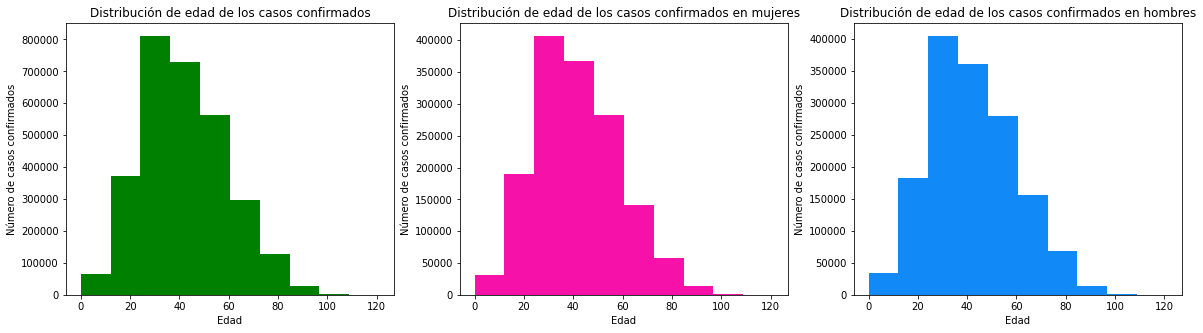

In [32]:
fig, axs = plt.subplots(ncols = 3, nrows = 1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"], color="g")
axs[0].set_title("Distribución de edad de los casos confirmados")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "MUJER"], color="#F611A9")
axs[1].set_title("Distribución de edad de los casos confirmados en mujeres")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

axs[2].hist(data_filtered["EDAD"][data_filtered["SEXO_"] == "HOMBRE"], color="#1189F6")
axs[2].set_title("Distribución de edad de los casos confirmados en hombres")
axs[2].set_xlabel("Edad")
axs[2].set_ylabel("Número de casos confirmados")


In [33]:
print("Resumen edad de casos positivos")
age_summary = summary(data_filtered["EDAD"])
age_summary

Resumen edad de casos positivos


{'minimo': 0,
 'Q1': 29.0,
 'mediana': 40.0,
 'Q2': 40.0,
 'Q3': 54.0,
 'max': 121,
 'IQR': 25.0,
 'media': 42.10955802983285}

**Se puede ver que la distribución varía poco entre hombres y mujeres, el 50% de los contagios están entre los 31 y 55 años de edad**

### Distribución de edad en casos hospitalizados y ambulatorios.

Text(0, 0.5, 'Número de casos confirmados')

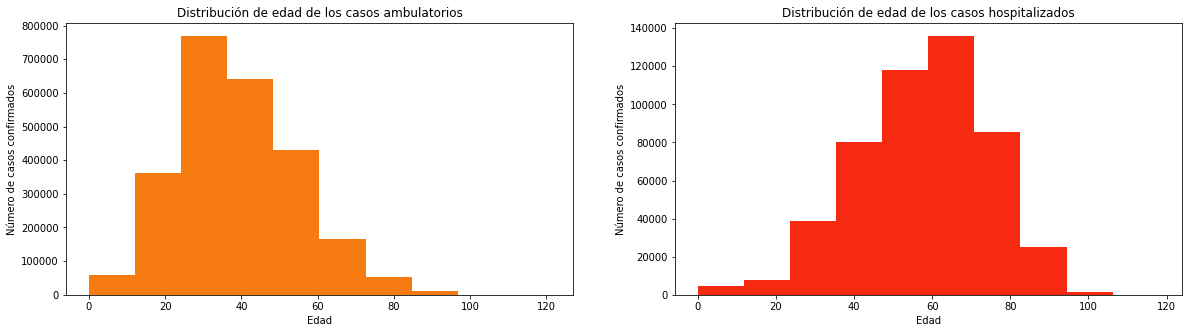

In [34]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0], color="#F67C11")
axs[0].set_title("Distribución de edad de los casos ambulatorios")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1], color="#F62911")
axs[1].set_title("Distribución de edad de los casos hospitalizados")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [35]:
print("Resumen edad de casos ambulatorios")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 0])
amb_age

Resumen edad de casos ambulatorios


{'minimo': 0,
 'Q1': 28.0,
 'mediana': 37.0,
 'Q2': 37.0,
 'Q3': 49.0,
 'max': 121,
 'IQR': 21.0,
 'media': 39.06544012056131}

In [36]:
print("Resumen edad de casos hospitalizados")
amb_age = summary(data_filtered["EDAD"][data_filtered["HOSPITALIZADO"] == 1])
amb_age

Resumen edad de casos hospitalizados


{'minimo': 0,
 'Q1': 47.0,
 'mediana': 58.0,
 'Q2': 58.0,
 'Q3': 69.0,
 'max': 118,
 'IQR': 22.0,
 'media': 57.36078250946292}

**Se puede apreciar que el grueso de los casos tratados ambulatoriamente están entre los 29 y 51 años de edad mientras que los hospitalizados estan entre los 48 y 70.**

### Distribución por edad de fallecidos

Text(0, 0.5, 'Número de casos confirmados')

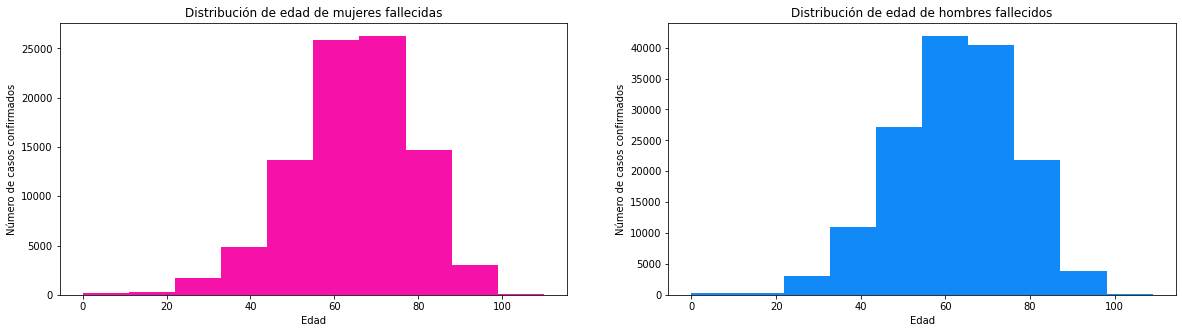

In [37]:
fig, axs = plt.subplots(ncols=2,nrows=1)
fig.set_size_inches(20,5)

axs[0].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)], color="#F611A9")
axs[0].set_title("Distribución de edad de mujeres fallecidas")
axs[0].set_xlabel("Edad")
axs[0].set_ylabel("Número de casos confirmados")

axs[1].hist(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)], color="#1189F6")
axs[1].set_title("Distribución de edad de hombres fallecidos")
axs[1].set_xlabel("Edad")
axs[1].set_ylabel("Número de casos confirmados")

In [38]:
print("Resumen edad en mujeres fallecidas")
female_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "MUJER")&(data_filtered["FALLECIDO"] == 1)])
female_deceased

Resumen edad en mujeres fallecidas


{'minimo': 0,
 'Q1': 56.0,
 'mediana': 65.0,
 'Q2': 65.0,
 'Q3': 74.0,
 'max': 110,
 'IQR': 18.0,
 'media': 64.10420870408961}

In [39]:
print("Resumen edad en hombres fallecidos")
male_deceased = summary(data_filtered["EDAD"][(data_filtered["SEXO_"] == "HOMBRE")&(data_filtered["FALLECIDO"] == 1)])
male_deceased

Resumen edad en hombres fallecidos


{'minimo': 0,
 'Q1': 53.0,
 'mediana': 63.0,
 'Q2': 63.0,
 'Q3': 73.0,
 'max': 109,
 'IQR': 20.0,
 'media': 62.555509643709264}

**El 50% de los fallecidos parece estar entre los 55 y 74 años de edad**

### Comparación de mortalidad en hombres y mujeres

In [40]:
table = pd.crosstab(data_filtered.SEXO_, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table

FALLECIDO,0,1,MORTALIDAD
SEXO_,,,
HOMBRE,1350352,150046,0.100004
MUJER,1400310,90693,0.060827


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

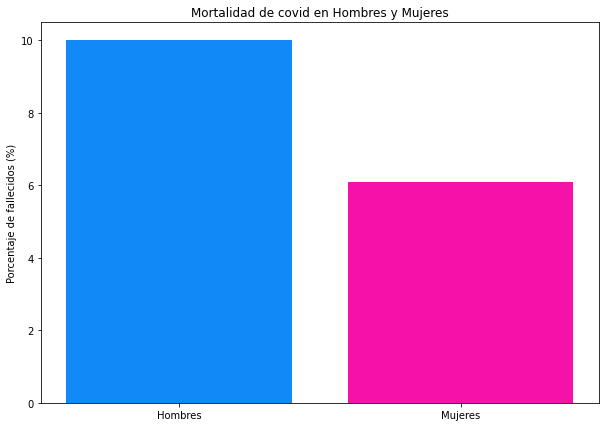

In [41]:
plt.figure(figsize = (10,7))
plt.bar(["Hombres"], table["MORTALIDAD"][0]*100, color = "#1189F6")
plt.bar(["Mujeres"], table["MORTALIDAD"][1]*100, color = "#F611A9")
plt.title("Mortalidad de covid en Hombres y Mujeres")
plt.ylabel("Porcentaje de fallecidos (%)")

## Mortalidad por estado y por sector

### Mortalidad por estado


In [42]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
ESTADO,,,
BS,48587,2039,0.040276
TC,89175,3817,0.041047
DF,897914,46067,0.048801
DG,35863,2342,0.061301
QT,72211,4782,0.062110
NL,143383,10460,0.067991
OC,53784,4062,0.070221
SP,70986,5490,0.071787
QR,43487,3368,0.071881


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

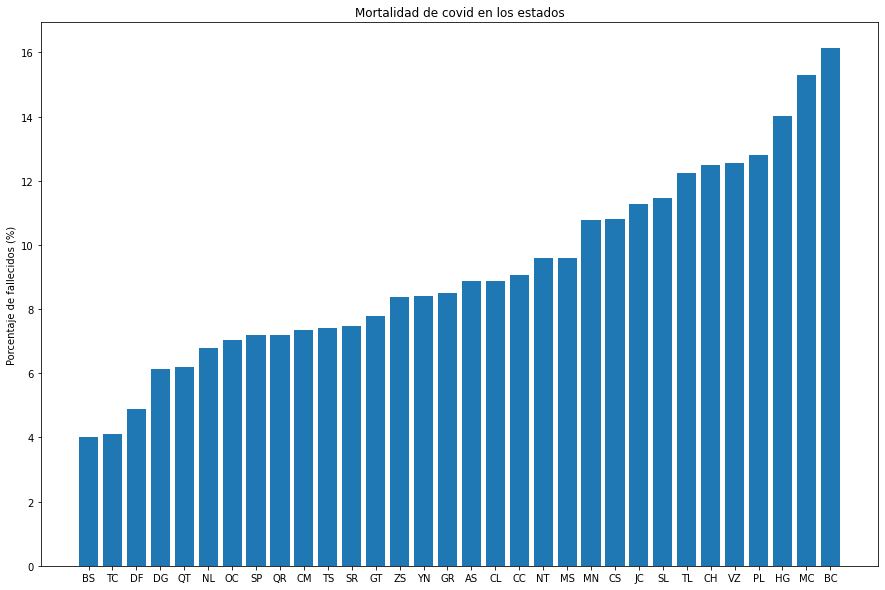

In [43]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid en los estados")
plt.ylabel("Porcentaje de fallecidos (%)")

### Mortalidad por sector de la salud

In [44]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["MORTALIDAD"])
table

FALLECIDO,0,1,MORTALIDAD
SECTOR_ATENDIDO,,,
DIF,878,2,0.002273
SSA,1569584,66178,0.040457
MUNICIPAL,2402,102,0.040735
PRIVADA,77889,4436,0.053884
SEMAR,8520,830,0.088770
CRUZ ROJA,272,27,0.090301
ESTATAL,29451,3453,0.104942
IMSS-BIENESTAR,16376,1937,0.105772
IMSS,933476,139277,0.129831


Text(0, 0.5, 'Porcentaje de fallecidos (%)')

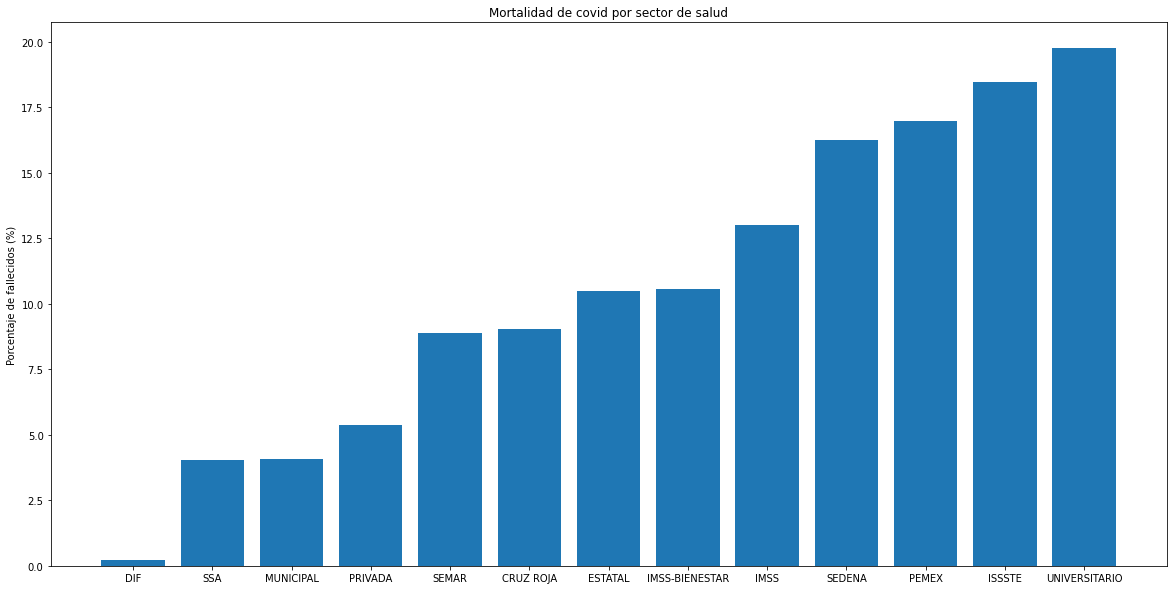

In [45]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad de covid por sector de salud")
plt.ylabel("Porcentaje de fallecidos (%)")

## Proporcion de enfermos grave de covid por estado y por sector

### Proporción de enfermos graves por estado

In [46]:
table = pd.crosstab(data_filtered.ESTADO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
ESTADO,,,
DG,35861,2344,0.061353
BS,47155,3471,0.068562
TC,85611,7381,0.079372
DF,861781,82200,0.087078
TS,69630,6960,0.090873
ZS,31677,3277,0.093752
CL,67214,7087,0.095382
YN,50709,5864,0.103654
NL,137867,15976,0.103846


Text(0, 0.5, 'Porcentaje de enfermos (%)')

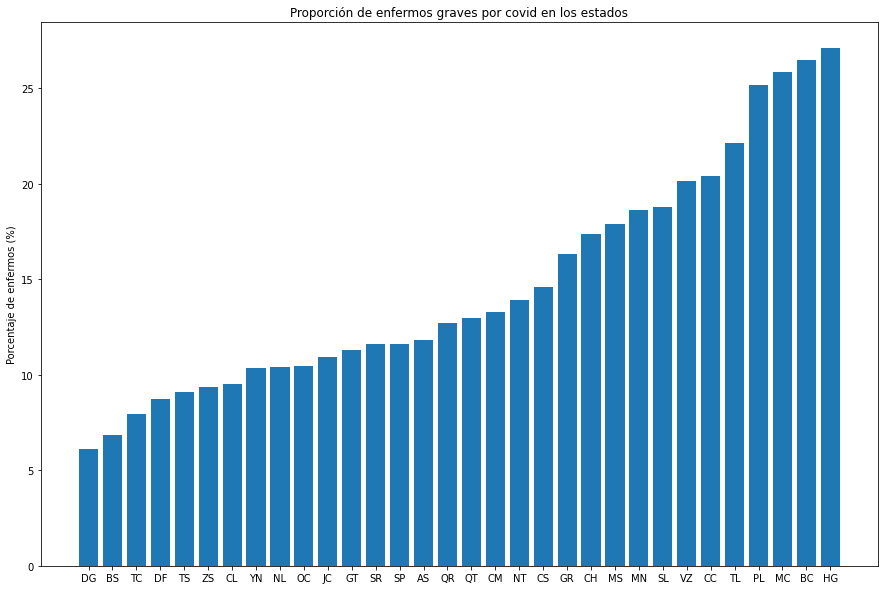

In [47]:
plt.figure(figsize = (15,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por covid en los estados")
plt.ylabel("Porcentaje de enfermos (%)")

### Proporción de enfermos graves por sector de salud

In [48]:
table = pd.crosstab(data_filtered.SECTOR_ATENDIDO, data_filtered.ENFERMEDAD_GRAVE)
table["PROPORCION"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["PROPORCION"])
table

ENFERMEDAD_GRAVE,0,1,PROPORCION
SECTOR_ATENDIDO,,,
DIF,850,30,0.034091
SSA,1494853,140909,0.086143
MUNICIPAL,2266,238,0.095048
CRUZ ROJA,263,36,0.120401
IMSS,904181,168572,0.157140
IMSS-BIENESTAR,14749,3564,0.194616
PRIVADA,65196,17129,0.208066
SEMAR,7200,2150,0.229947
SEDENA,13677,4258,0.237413


Text(0, 0.5, 'Porcentaje de enfermos graves (%)')

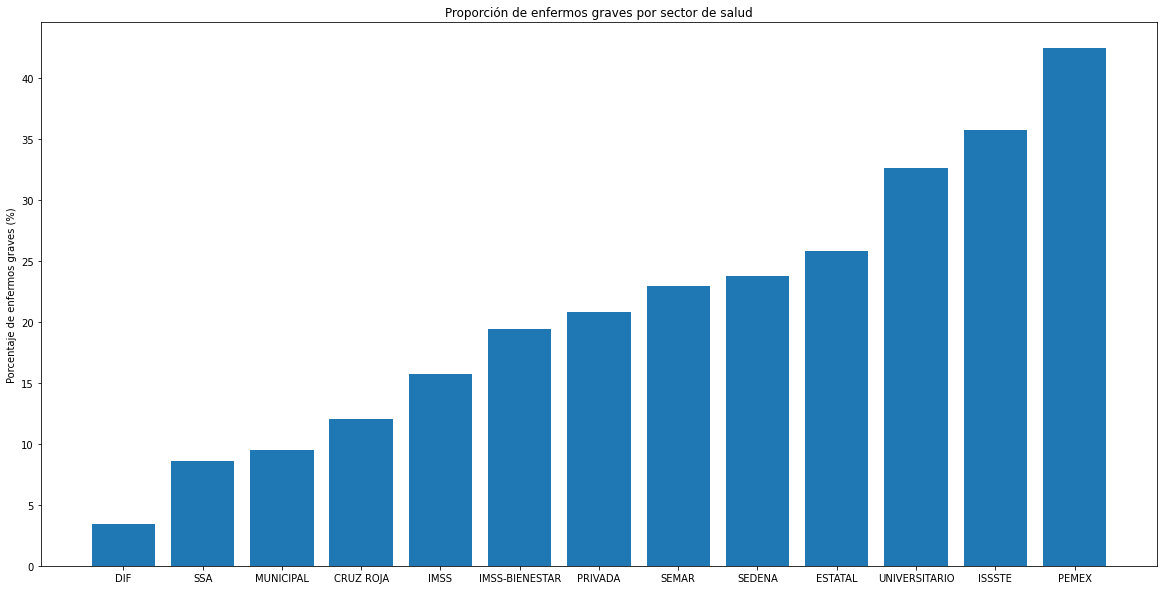

In [49]:
plt.figure(figsize = (20,10))
plt.bar(table.index,table["PROPORCION"]*100)
plt.title("Proporción de enfermos graves por sector de salud")
plt.ylabel("Porcentaje de enfermos graves (%)")

## Mortalidad por días de espera
Se obtendrá la mortalidad según los días entre que el paciente presento síntomas y cuando se atendió en una unidad de salud.

Text(0.5, 0, 'Dias pasados entre el inicio de los sintomas e ingreso a una institucion de salud')

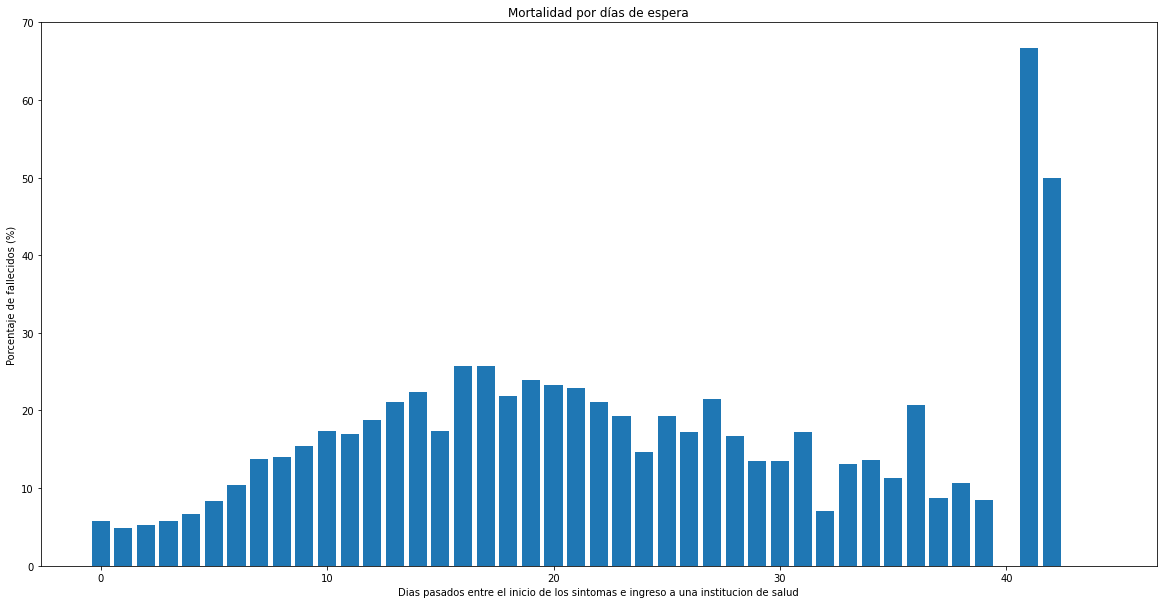

In [50]:
table = pd.crosstab(data_filtered.TIEMPO_ESPERA, data_filtered.FALLECIDO)
table["MORTALIDAD"] = table[1]/(table[0]+table[1])
table = table.sort_values(by = ["TIEMPO_ESPERA"])
table = table[0:45]

plt.figure(figsize = (20,10))
plt.bar(table.index,table["MORTALIDAD"]*100)
plt.title("Mortalidad por días de espera")
plt.ylabel("Porcentaje de fallecidos (%)")
plt.xlabel("Dias pasados entre el inicio de los sintomas e ingreso a una institucion de salud")

Se puede ver que aumenta la mortalidad entre más días de espera.

##  Mortalidad y Positividad a lo largo de la pandemia
Se obtendrá la mortalidad y positividad por semana desde la primera semana del 2020 (Se registraban solamente casos sospechosos los primeros meses del 2020)

In [51]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(covid_df, dates)
cases_by_day = pd.DataFrame(cases_by_day)

### Gráfica de casos


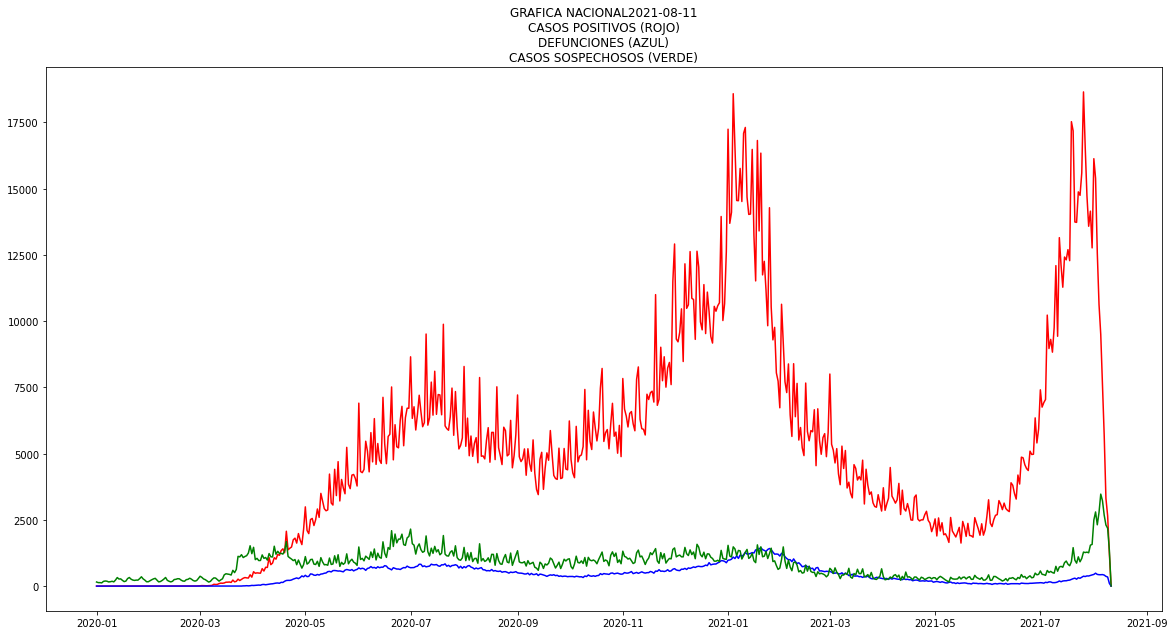

In [52]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL"+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

### Separación de semanas

In [53]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [54]:
cases_by_day.sample(10)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,SEMANA
446,2021-03-22,4411,16665,377,343,63
100,2020-04-10,1074,1663,1228,78,14
522,2021-06-06,2696,8549,317,81,74
66,2020-03-07,21,210,178,0,9
18,2020-01-19,0,276,285,0,2
348,2020-12-14,12638,19172,1577,737,49
521,2021-06-05,2671,8834,361,95,74
102,2020-04-12,868,1439,1100,87,14
402,2021-02-06,6461,14464,719,998,57
204,2020-07-23,5882,5463,1134,784,29


In [55]:
cases_by_day.tail(3)

,FECHA,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,SEMANA
586,2021-08-09,2651,6386,2183,343,83
587,2021-08-10,1222,2814,1345,102,83
588,2021-08-11,0,9,5,2,84


In [56]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()
cases_by_week.sample(5)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES
SEMANA,,,,
80,95696,161930,6508,1571
22,34035,32136,7581,4699
70,14460,76297,1796,964
13,3730,8934,7661,275
71,14343,76776,2082,788


### Mortalidad

In [57]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]
cases_by_week.head(10)

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD
SEMANA,,,,,
0,0,963,1092,0,NaN
1,0,1278,1481,0,NaN
2,0,1508,1716,0,NaN
3,0,1419,1799,0,NaN
4,0,1226,1561,0,NaN
5,0,1393,1575,0,NaN
6,0,1242,1579,0,NaN
7,10,1208,1657,0,0.0
8,59,1490,1866,0,0.0


In [58]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])
cases_by_week.head()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD,DIA
SEMANA,,,,,,
0,0,963,1092,0,NaN,2020-01-01
1,0,1278,1481,0,NaN,2020-01-08
2,0,1508,1716,0,NaN,2020-01-15
3,0,1419,1799,0,NaN,2020-01-22
4,0,1226,1561,0,NaN,2020-01-29


In [59]:
cases_by_week.tail()

,CASOS_POSITIVOS,CASOS_NEGATIVOS,CASOS_SOSPECHOSOS,DEFUNCIONES,MORTALIDAD,DIA
SEMANA,,,,,,
80,95696,161930,6508,1571,0.016417,2021-07-14
81,107895,166867,7457,2239,0.020752,2021-07-21
82,99319,139432,13259,2958,0.029783,2021-07-28
83,40564,64412,17981,2521,0.062149,2021-08-04
84,0,9,5,2,inf,2021-08-11


Text(0, 0.5, 'Mortalidad en porcentaje (%)')

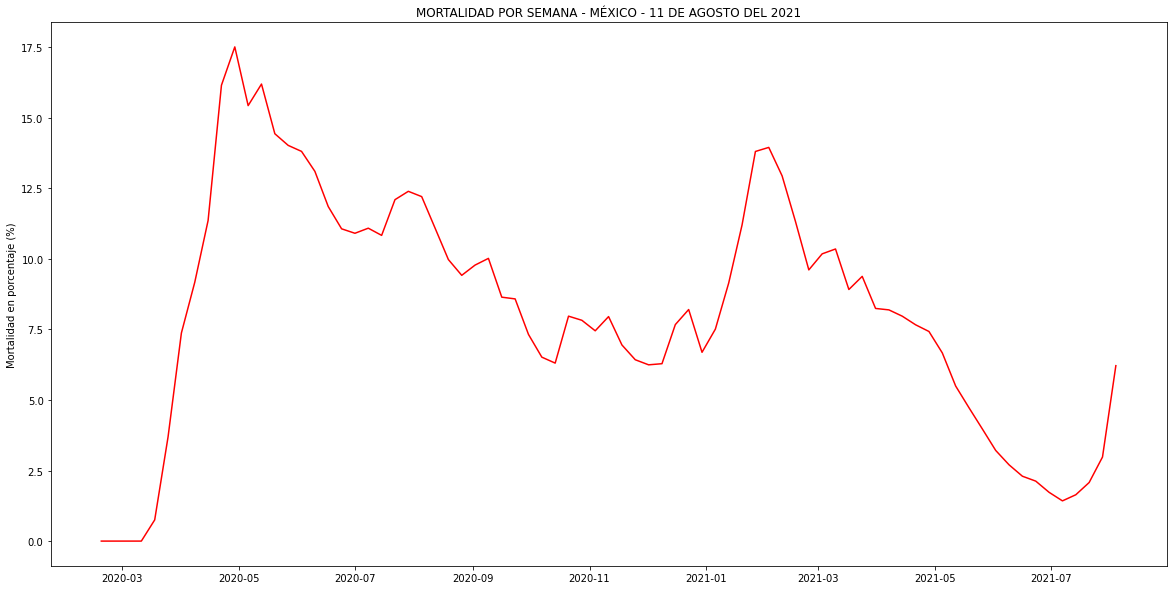

In [61]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

Se puede apreciar que los maximos de la mortalidad coinciden con los picos de las olas que han habido en México.


### Positividad

In [62]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

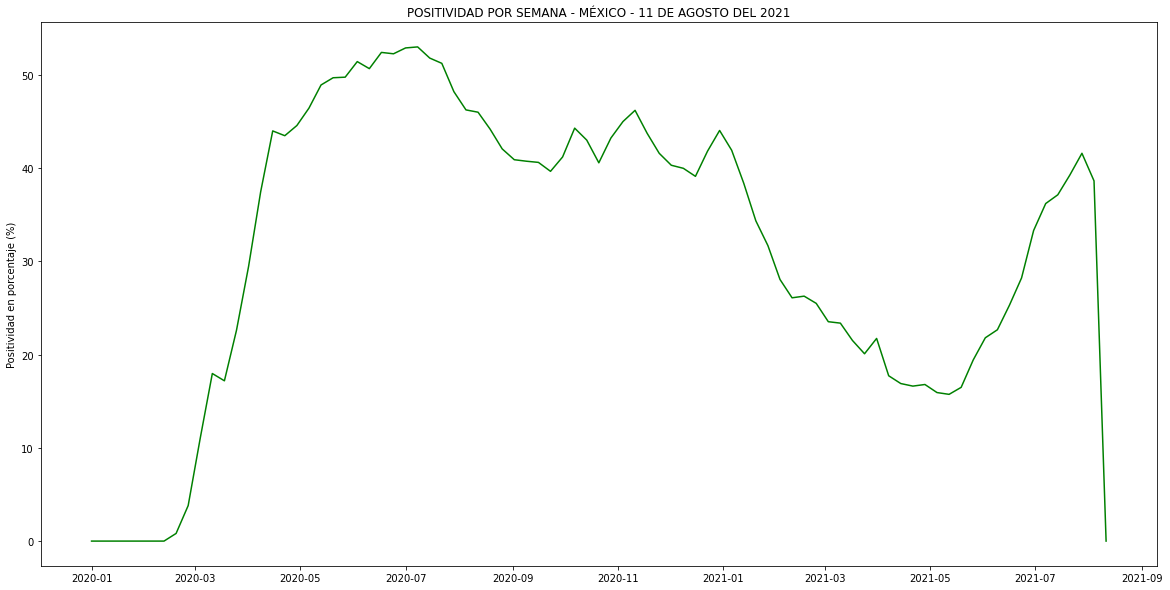

In [63]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

Al igual que con la mortalidad, la positividad cambió durante la pandemia de covid y sus puntos más altos coinciden con los picos de las olas de la epidemia que han habido.

## Guardado Dataset
Se guarda el dataset después de ser limpiado y con datos procesados

In [64]:
dataset_file = "210727COVID19MEXICO_filtered.csv"
data_filtered.to_csv(os.path.join(main_dataset_path, dataset_file))

## Efecto de las vacunas en los grupos de población

In [64]:
data_filtered.sample(5)

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,PAIS_ORIGEN,UCI,RESULTADO,TIEMPO_ESPERA,FALLECIDO,ENFERMEDAD_GRAVE,HOSPITALIZADO,SEXO_,SECTOR_ATENDIDO,ESTADO
2251114,2021-08-11,1e147e,2,12,15,2,15,15,33,1,...,97,0,1,2,0,0,0,HOMBRE,SSA,MC
1657199,2021-08-11,d74757,2,12,28,1,28,28,41,1,...,97,0,1,2,0,0,0,MUJER,SSA,TS
2476942,2021-08-11,9cc643,2,4,23,1,30,23,5,1,...,97,0,1,3,0,0,0,MUJER,IMSS,QR
1550326,2021-08-11,70e9b4,2,4,19,1,19,19,21,1,...,97,0,1,2,0,0,0,MUJER,IMSS,NL
2580582,2021-08-11,16aade,2,12,24,1,9,24,37,1,...,97,0,1,2,0,0,0,MUJER,SSA,SP


In [65]:
data_filtered.shape

(2991401, 48)

Se separará el dataframe `data_filtered` en 6 grupos:
* Mayores de 60 años
* Entre 50 y 59 años
* Entre 40 y 49 años
* Entre 30 y 39 años
* Entre 20 y 29 años
* Menores de 20 años

In [66]:
data_by_age = {}

In [67]:
data_by_age[">60"] = covid_df[covid_df["EDAD"] >= 60].copy()

In [68]:
data_by_age["50-59"] = covid_df[(covid_df["EDAD"] >= 50) & (covid_df["EDAD"] <= 59)].copy()

In [69]:
data_by_age["40-49"] = covid_df[(covid_df["EDAD"] >= 40) & (covid_df["EDAD"] <= 49)].copy()

In [70]:
data_by_age["30-39"] = covid_df[(covid_df["EDAD"] >= 30) & (covid_df["EDAD"] <= 39)].copy()

In [71]:
data_by_age["20-29"] = covid_df[(covid_df["EDAD"] >= 20) & (covid_df["EDAD"] <= 29)].copy()

In [72]:
data_by_age["<20"] = covid_df[covid_df["EDAD"] <= 19].copy()

In [73]:
keys = data_by_age.keys()
for key in keys:
  print(f"GRUPO EDAD {key}")
  comulative_cases = covid.getComulativeCases(data_by_age[key])
  covid.printCumulativeCases(comulative_cases, date)

GRUPO EDAD >60
Fecha de actualización: 2021-08-11

  Total de casos estudiados: 1158440

  Casos Positivos a SARS-CoV-2: 497794

  Casos No Positivos a SARS-CoV-2: 597996

  Casos Con Resultado Pendiente: 62650

  Defunciones Positivas a SARS-CoV-2: 153062

  Tasa de Letalidad: 30.748%

  Tasa de Positividad : 45.428%

GRUPO EDAD 50-59
Fecha de actualización: 2021-08-11

  Total de casos estudiados: 1279222

  Casos Positivos a SARS-CoV-2: 471490

  Casos No Positivos a SARS-CoV-2: 740606

  Casos Con Resultado Pendiente: 67126

  Defunciones Positivas a SARS-CoV-2: 51210

  Tasa de Letalidad: 10.861%

  Tasa de Positividad : 38.899%

GRUPO EDAD 40-49
Fecha de actualización: 2021-08-11

  Total de casos estudiados: 1715944

  Casos Positivos a SARS-CoV-2: 600049

  Casos No Positivos a SARS-CoV-2: 1021359

  Casos Con Resultado Pendiente: 94536

  Defunciones Positivas a SARS-CoV-2: 27536

  Tasa de Letalidad: 4.589%

  Tasa de Positividad : 37.008%

GRUPO EDAD 30-39
Fecha de actualiza

In [74]:
table_age = pd.crosstab(data_filtered.EDAD,data_filtered.FALLECIDO)
table_age["MORTALIDAD"] = table_age[1]/(table_age[0]+table_age[1])*100
table_age = table_age.sort_values(by = ["EDAD"])

In [75]:
table_age["MORTALIDAD"].values

array([ 4.77404403,  2.57082896,  0.95057034,  0.70351759,  0.55935364,
        0.30589544,  0.36057692,  0.36844387,  0.34084454,  0.27624309,
        0.34927866,  0.19713497,  0.27539106,  0.2288539 ,  0.18319395,
        0.24329256,  0.28150455,  0.33673577,  0.21763696,  0.23833736,
        0.35159912,  0.33151461,  0.33954796,  0.34314178,  0.42986732,
        0.41337962,  0.58026793,  0.56417893,  0.68304272,  0.73580394,
        0.92332453,  0.98202276,  1.13362133,  1.20321463,  1.44149624,
        1.63866386,  1.79507398,  1.91902248,  2.24138733,  2.44449036,
        2.7260366 ,  3.08853101,  3.47575978,  3.7859571 ,  4.28863869,
        4.7804878 ,  5.13548808,  5.56257901,  5.87884016,  6.39234482,
        7.01186624,  7.84969955,  8.63203667,  9.36266447, 10.14705248,
       11.22552255, 12.68807093, 13.19217481, 14.30414289, 15.82114114,
       17.30550285, 19.20835068, 20.97015898, 22.33887043, 23.46766971,
       25.68916704, 26.15132861, 27.68770267, 29.90421029, 30.93

Text(0.5, 1.0, 'LETALIDAD POR EDAD')

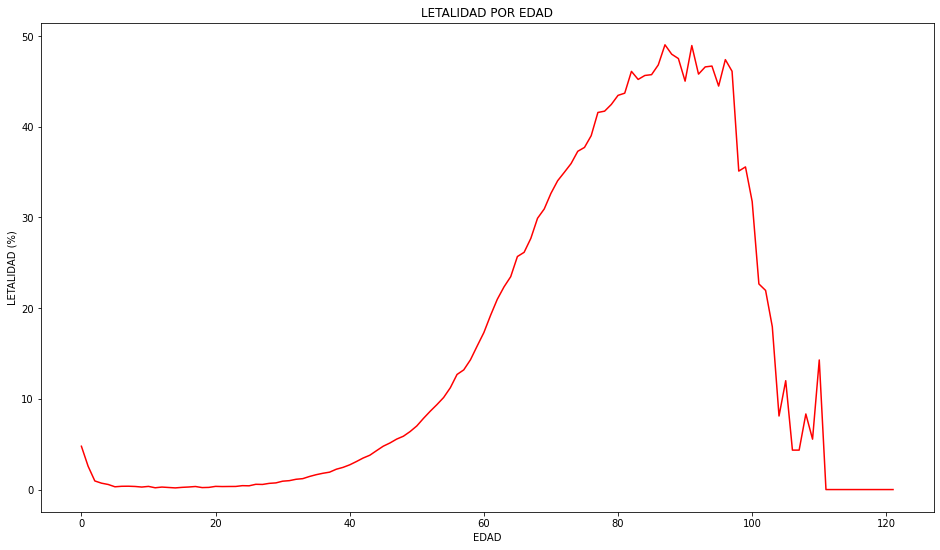

In [76]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

sns.lineplot(x = table_age.index, y = table_age["MORTALIDAD"].values, ax = ax, color = "red")
ax.set_ylabel("LETALIDAD (%)")
ax.set_title("LETALIDAD POR EDAD")

### Graficas de casos, mortalidad y positividad por grúpos de edad
Se espera ver una disminución de la mortalidad y casos en los grupos de edad que ya han sido vacunados

#### Mayores de 60 años

In [77]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age[">60"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

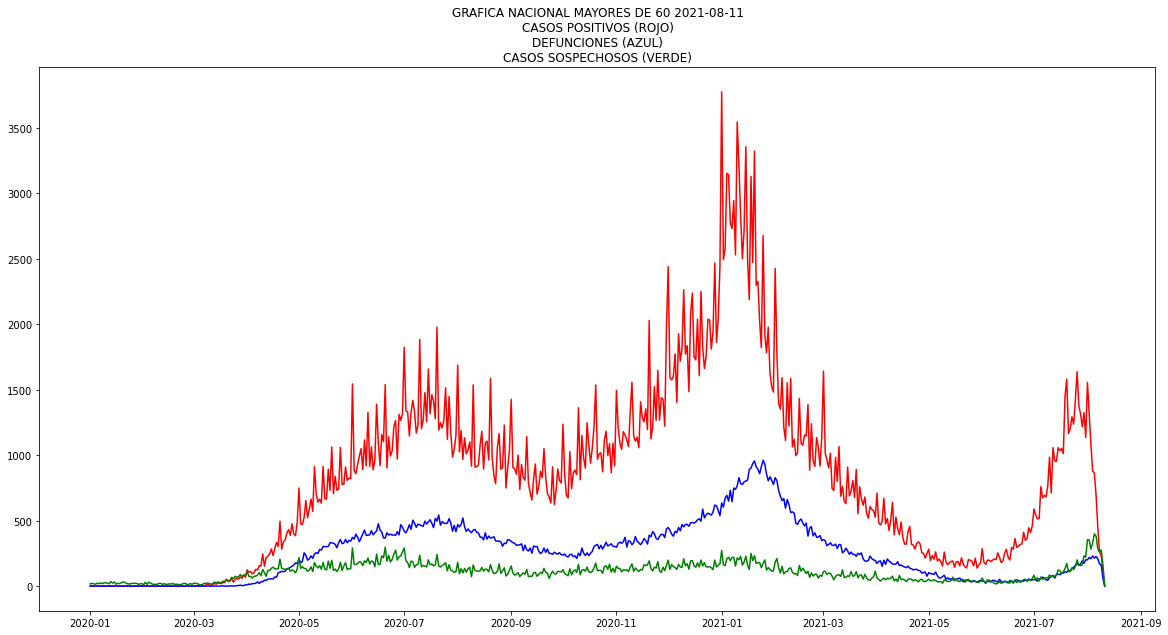

In [78]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL MAYORES DE 60 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [79]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [80]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [81]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [82]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

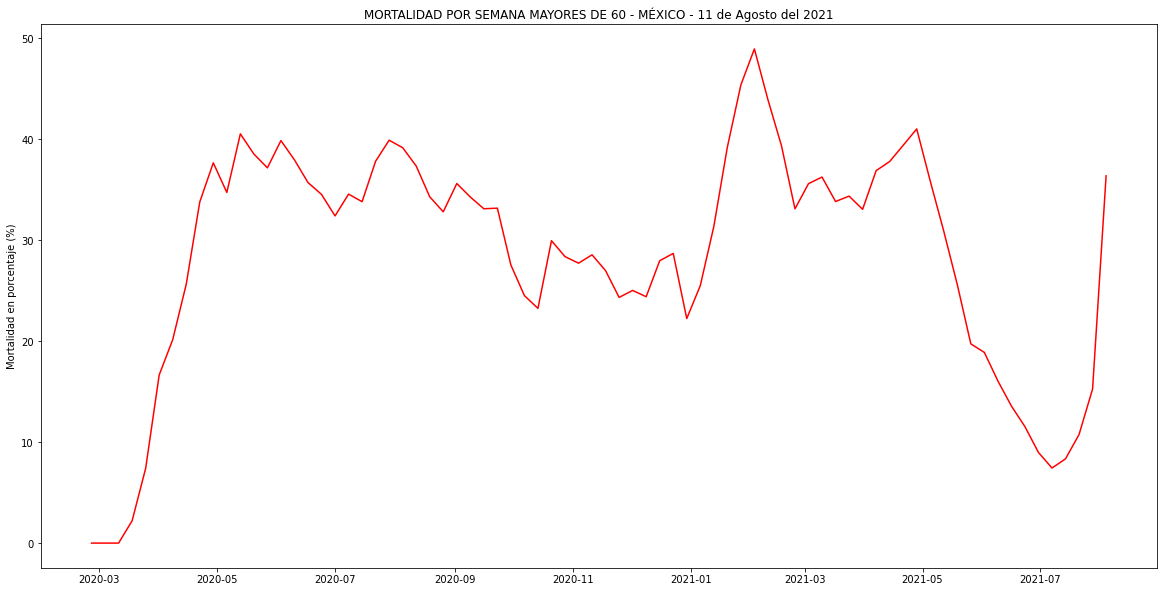

In [84]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA MAYORES DE 60 - MÉXICO - 11 de Agosto del 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [85]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

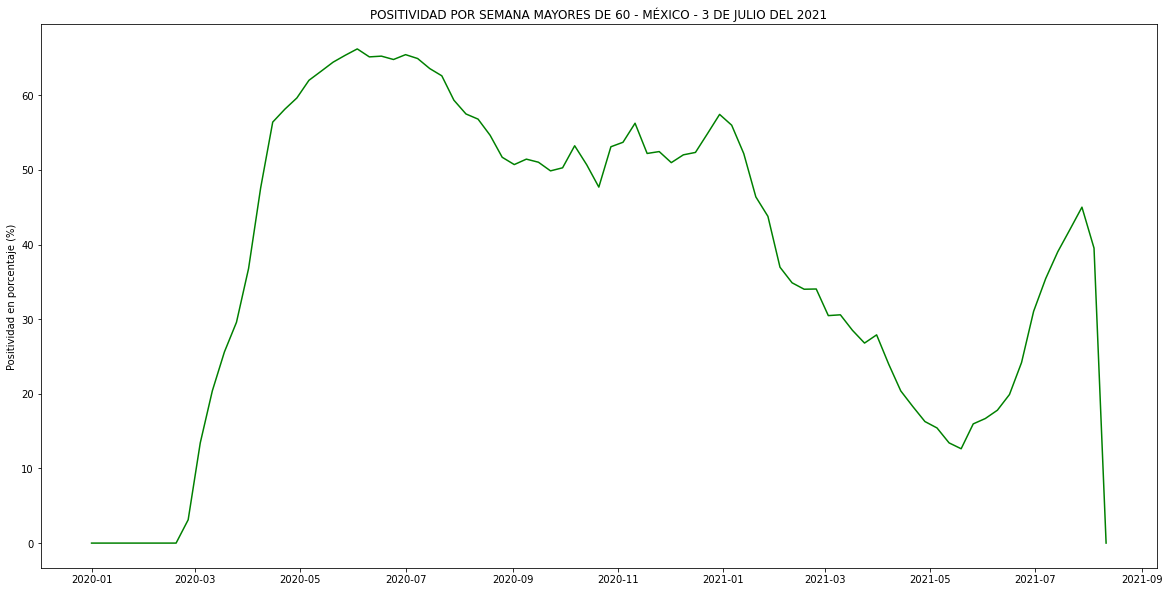

In [86]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA MAYORES DE 60 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 50 y 59 años

In [87]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["50-59"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

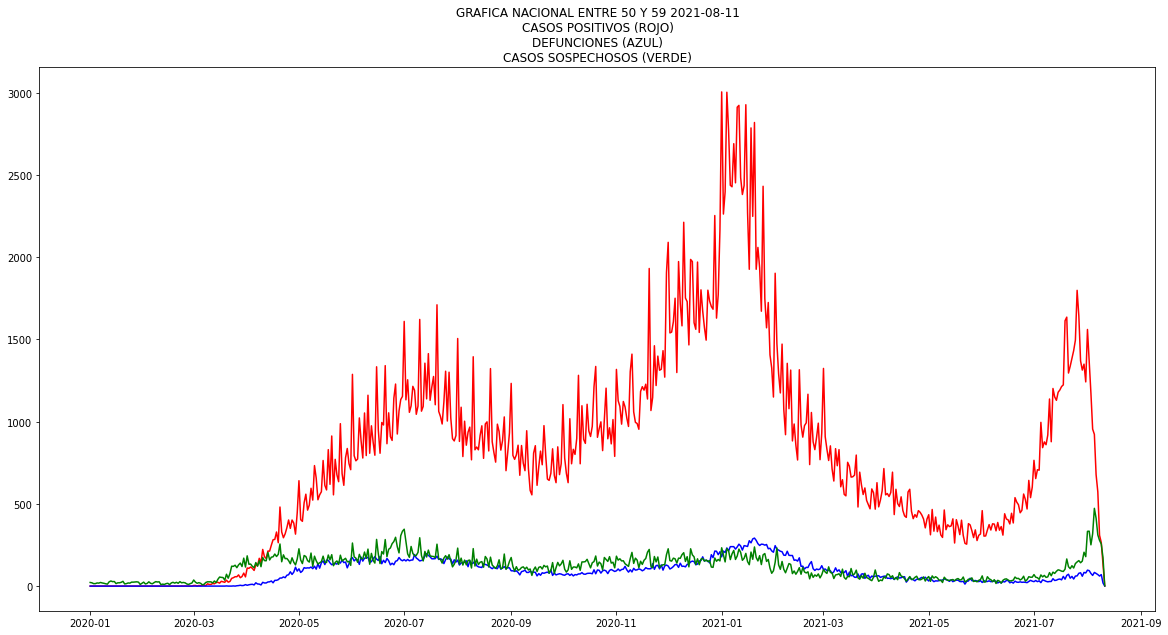

In [89]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 50 Y 59 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [90]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [91]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [92]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [93]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

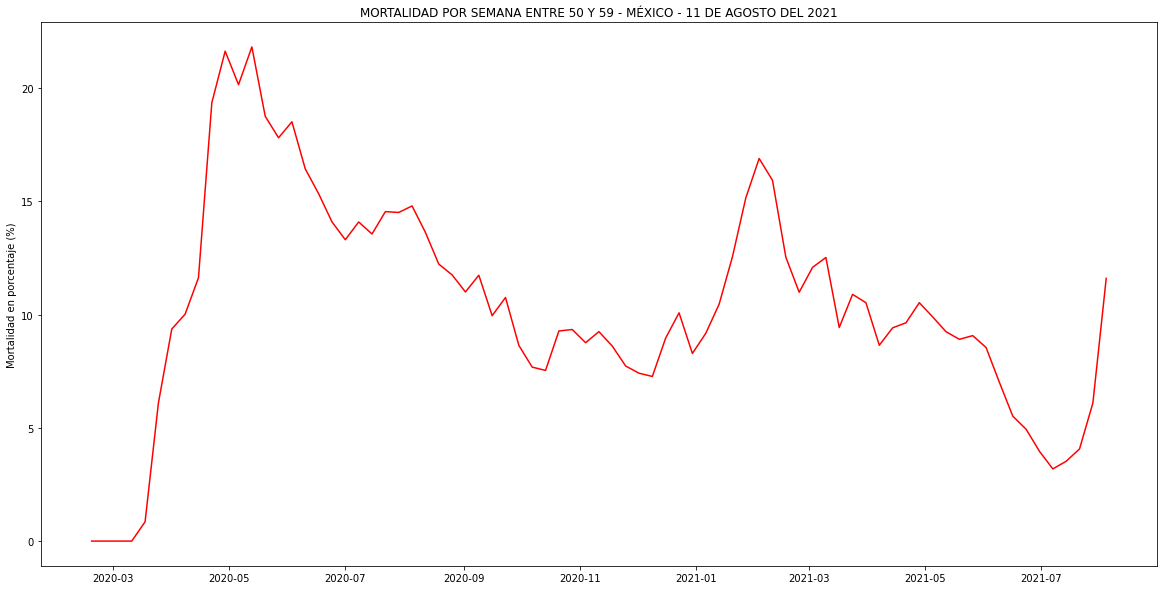

In [94]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 50 Y 59 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [95]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

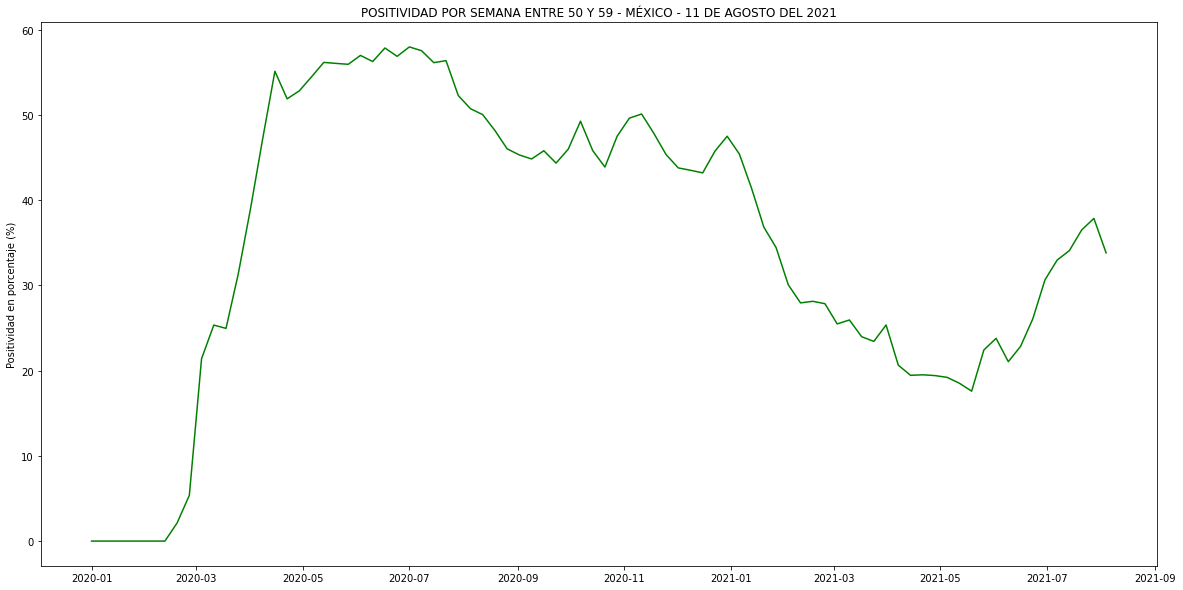

In [96]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 50 Y 59 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 40 y 49 años

In [97]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["40-49"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

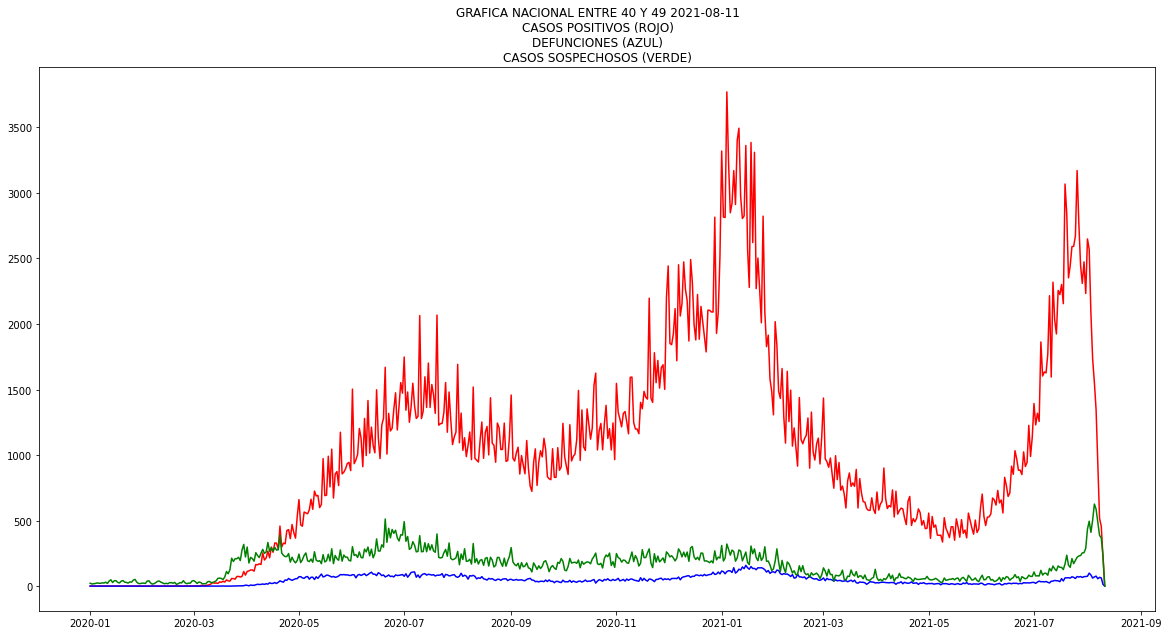

In [98]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 40 Y 49 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [99]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [100]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [101]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [102]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

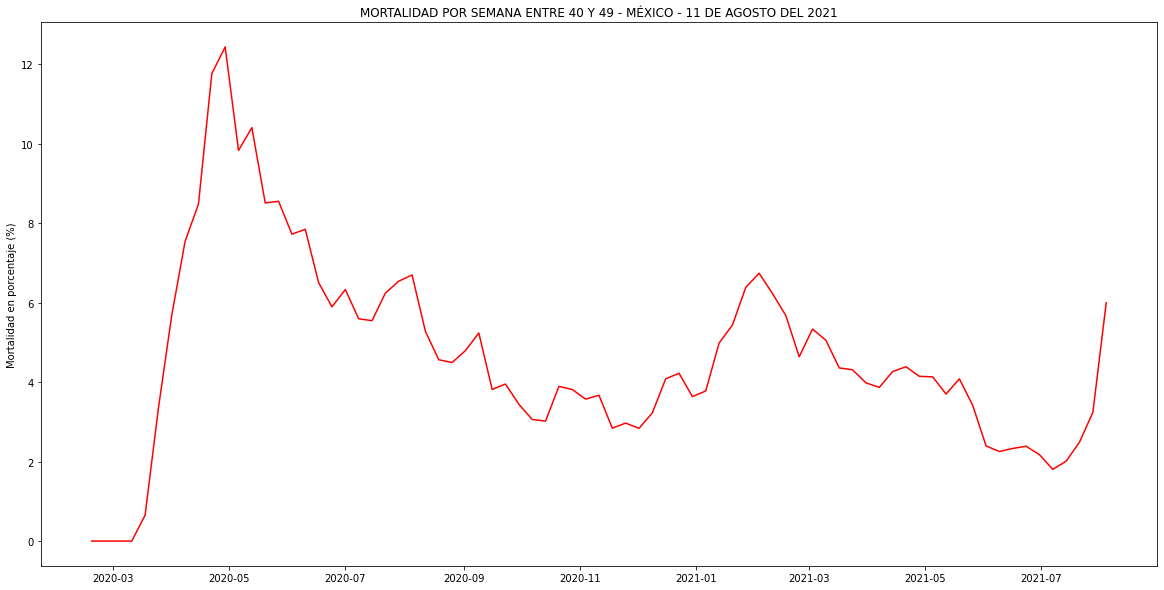

In [103]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 40 Y 49 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [104]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

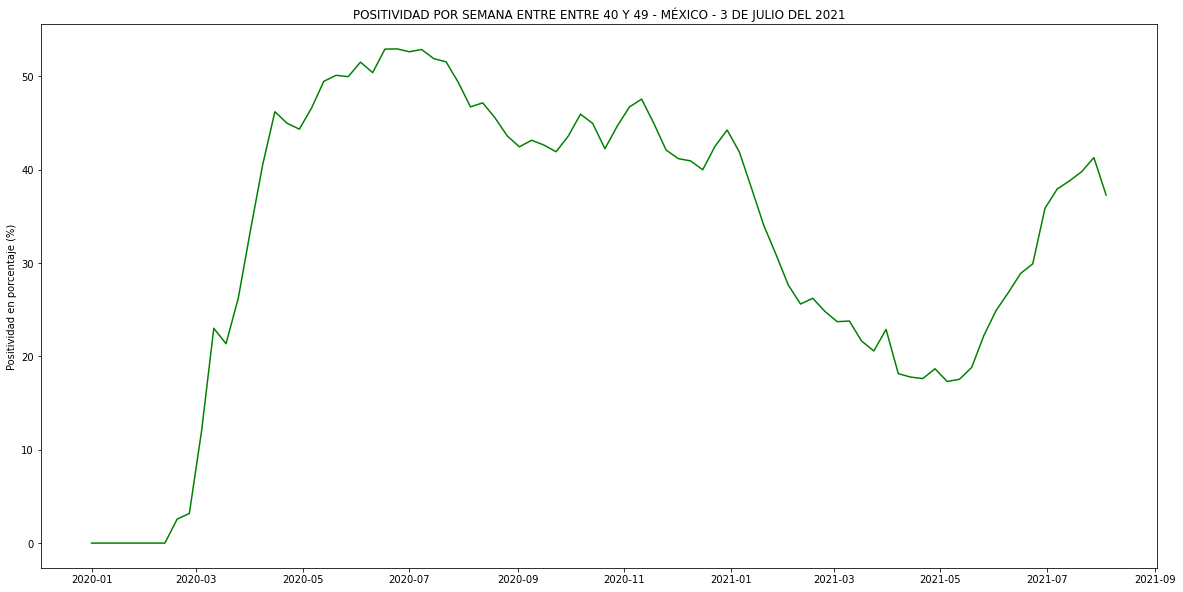

In [105]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE ENTRE 40 Y 49 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 30 y 39 años

In [106]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["30-39"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

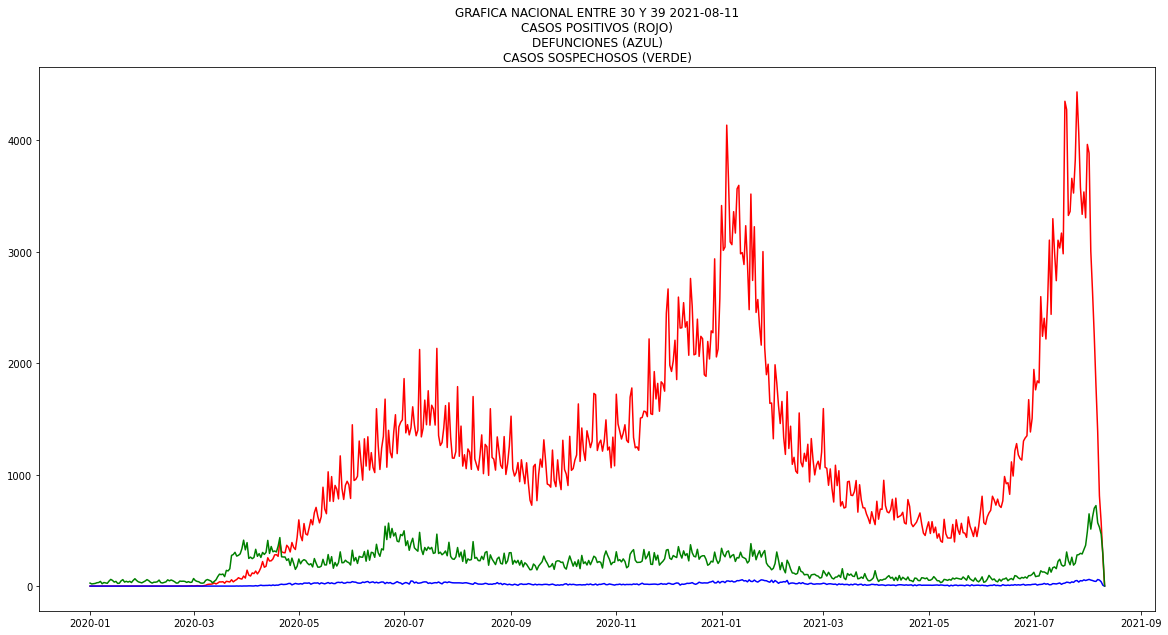

In [107]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 30 Y 39 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [109]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [110]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [111]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [113]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

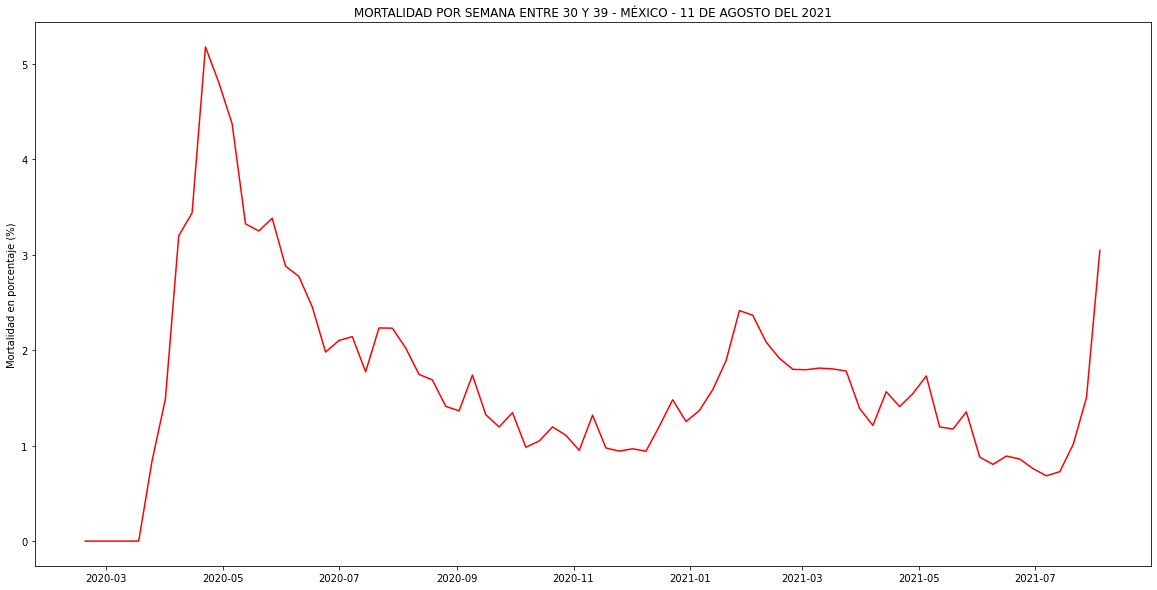

In [114]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 30 Y 39 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [115]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

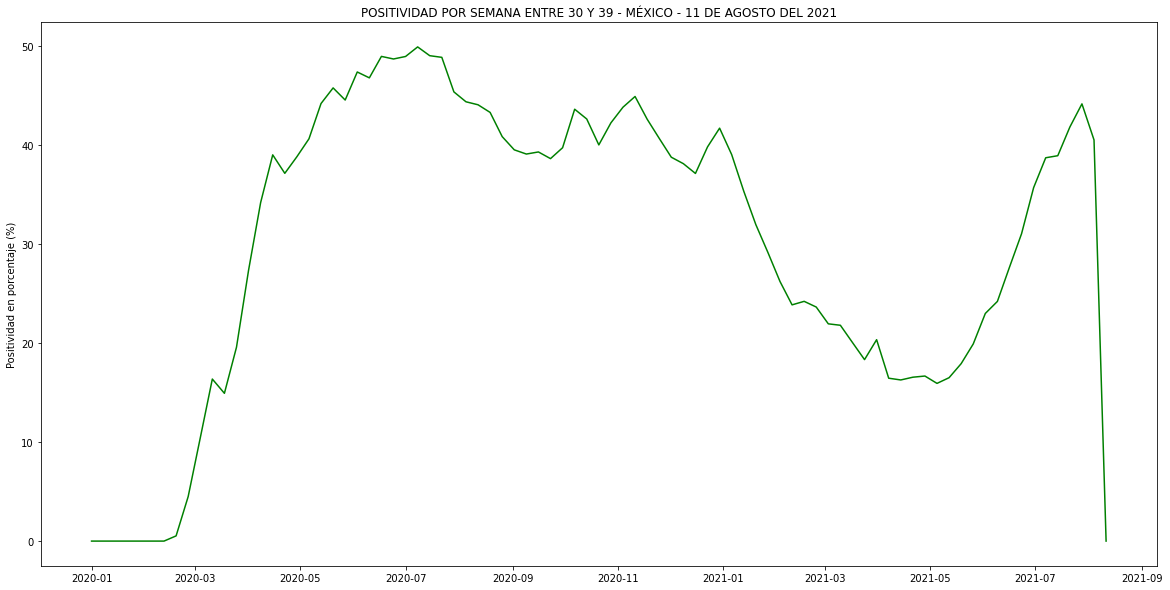

In [116]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 30 Y 39 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Entre 20 y 29 años

In [117]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["20-29"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

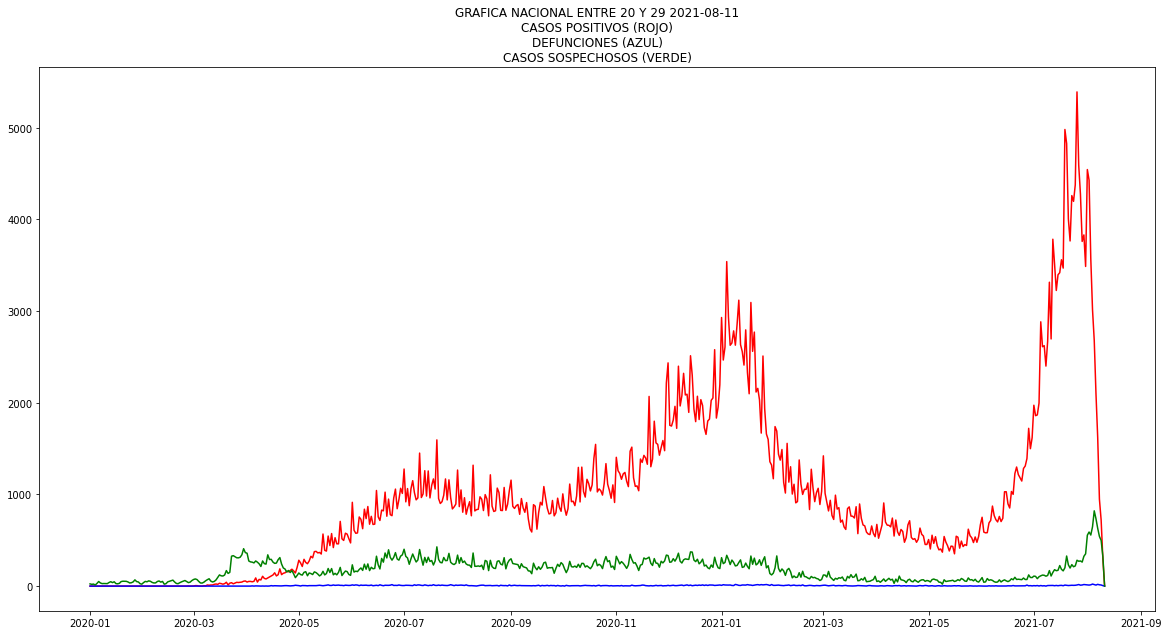

In [118]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL ENTRE 20 Y 29 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [119]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [120]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [121]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [122]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

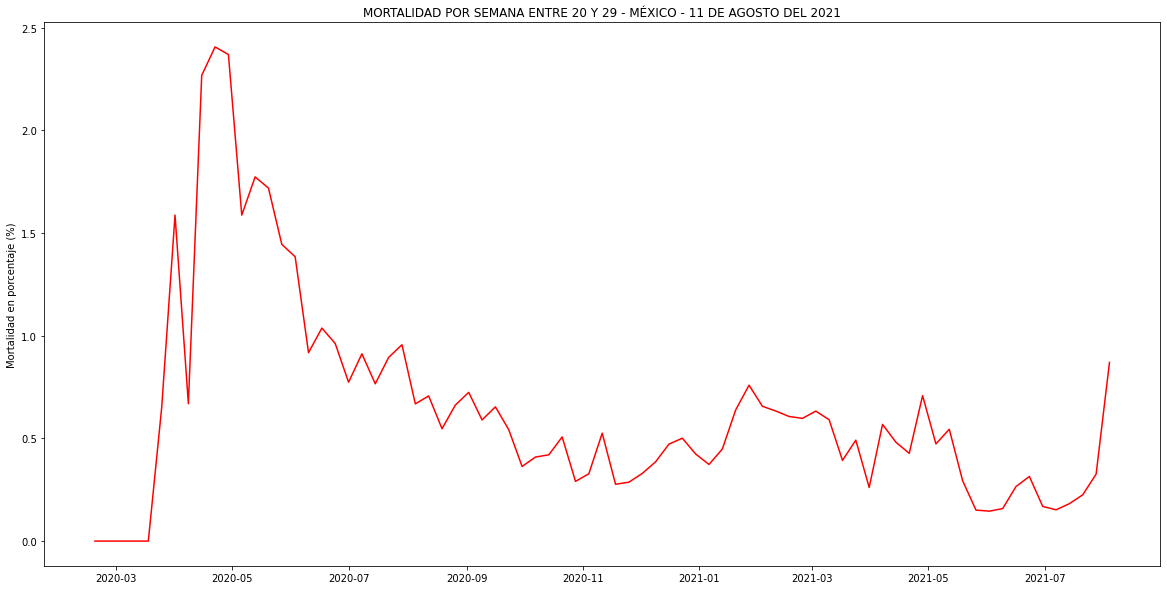

In [123]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA ENTRE 20 Y 29 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [124]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

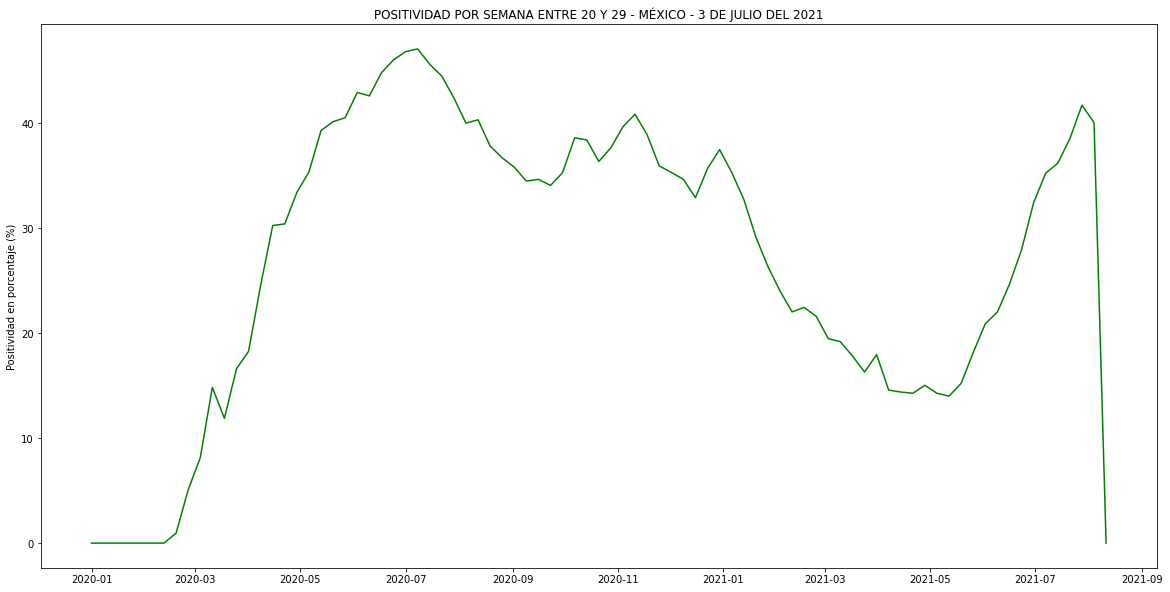

In [125]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA ENTRE 20 Y 29 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

#### Menores de 20 años

In [126]:
# Para esta sección se usará el dataset original, ya se usará un método externo que solo funciona con este
dates = covid.getDateList(date)

cases_by_day = covid.getCasesByDay(data_by_age["<20"], dates)
cases_by_day = pd.DataFrame(cases_by_day)

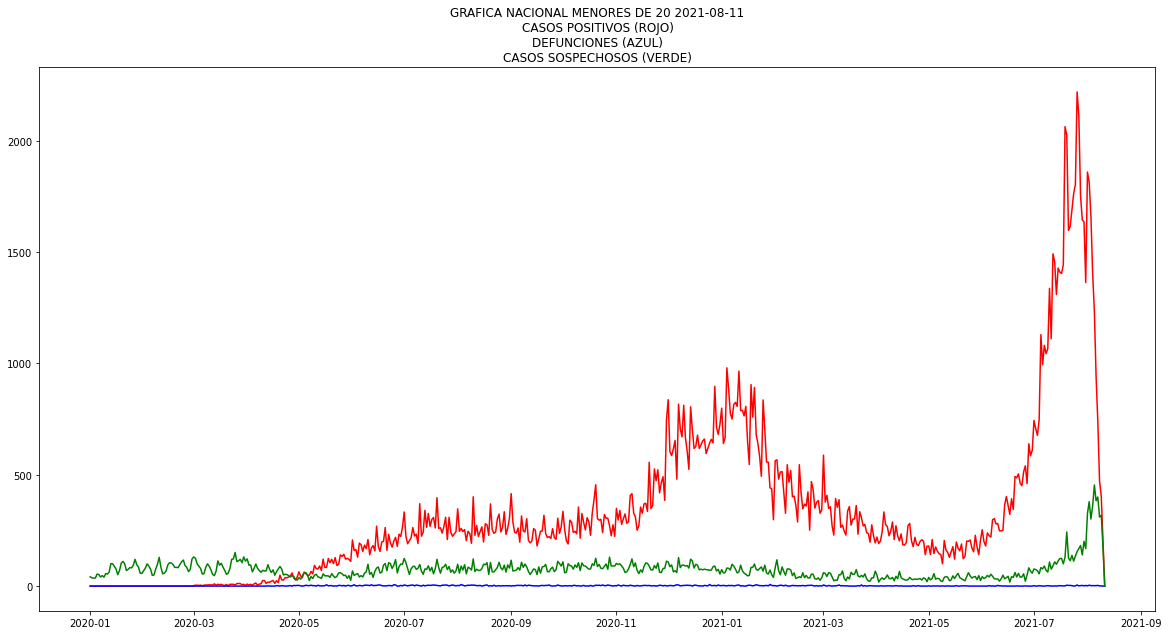

In [127]:
cases_by_day["FECHA"] = pd.to_datetime(cases_by_day["FECHA"], unit='ns')

plt.figure(figsize = (20,10))
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_POSITIVOS"],"r")
plt.plot(cases_by_day["FECHA"],cases_by_day["DEFUNCIONES"],"b")
plt.plot(cases_by_day["FECHA"],cases_by_day["CASOS_SOSPECHOSOS"],"g")
plt.title("GRAFICA NACIONAL MENORES DE 20 "+ date + "\nCASOS POSITIVOS (ROJO)\nDEFUNCIONES (AZUL)\nCASOS SOSPECHOSOS (VERDE)")
plt.show()

In [128]:
cases_by_day["SEMANA"] = cases_by_day["FECHA"].apply(lambda x: int((x - datetime(2020,1,1)).days/7))

In [129]:
cases_by_week = cases_by_day.groupby(["SEMANA"]).sum()

##### Mortalidad

In [130]:
cases_by_week["MORTALIDAD"] = cases_by_week["DEFUNCIONES"]/cases_by_week["CASOS_POSITIVOS"]

In [131]:
# La columna DIA se usará para gráficar las fechas
cases_by_week["SEMANA"] = cases_by_week.index

cases_by_week["DIA"] = cases_by_week["SEMANA"].apply(lambda x: datetime(2020,1,1) + timedelta(days = 7*x))
cases_by_week = cases_by_week.drop(columns=["SEMANA"])

Text(0, 0.5, 'Mortalidad en porcentaje (%)')

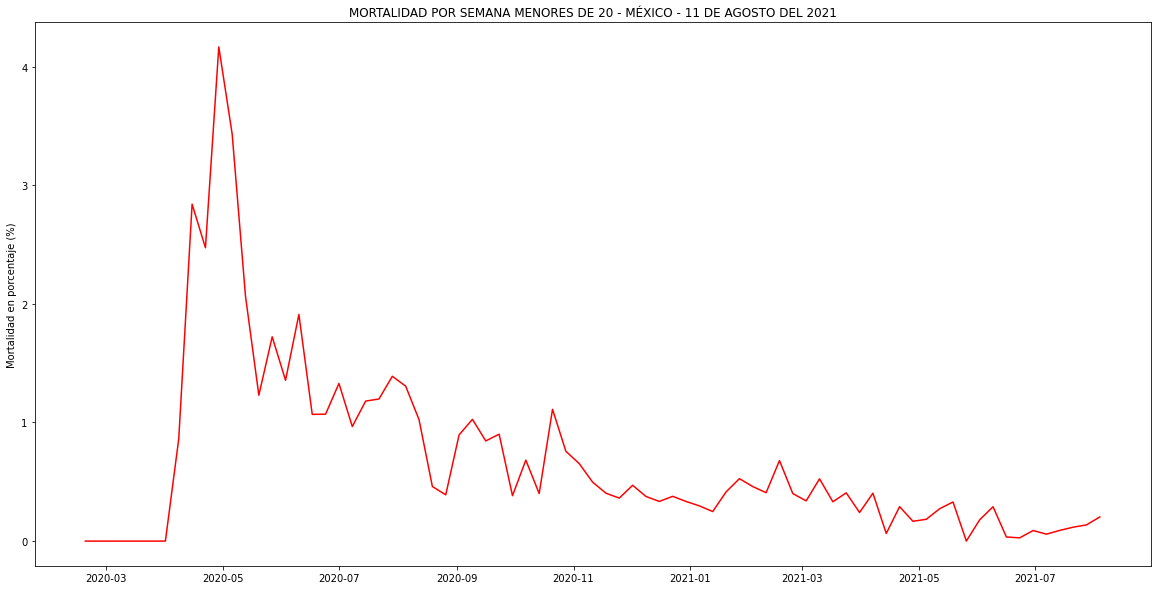

In [132]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["MORTALIDAD"]*100,"r")
plt.title("MORTALIDAD POR SEMANA MENORES DE 20 - MÉXICO - 11 DE AGOSTO DEL 2021")
plt.ylabel("Mortalidad en porcentaje (%)")

##### Positividad

In [133]:
cases_by_week["POSITIVIDAD"] = cases_by_week["CASOS_POSITIVOS"]/(cases_by_week["CASOS_POSITIVOS"] + cases_by_week["CASOS_NEGATIVOS"])

Text(0, 0.5, 'Positividad en porcentaje (%)')

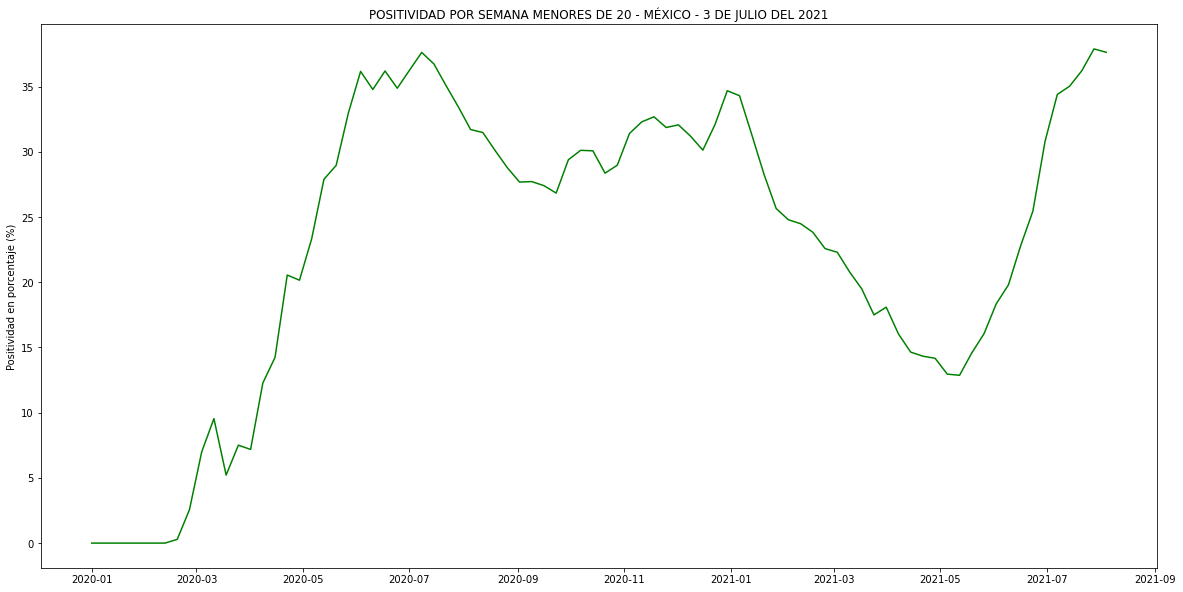

In [134]:
plt.figure(figsize = (20,10))
plt.plot(cases_by_week["DIA"],cases_by_week["POSITIVIDAD"]*100,"g")
plt.title("POSITIVIDAD POR SEMANA MENORES DE 20 - MÉXICO - 3 DE JULIO DEL 2021")
plt.ylabel("Positividad en porcentaje (%)")

## Mortalidad en condiciones específicas
Se obtendrá la mortalidad y la incidancia de hospitalización y probabilidad de obtener enfermedad grave para algunos casos específicos.

### Caso Específico 1:

* SEXO_: HOMBRE
* EDAD: 21
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [135]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1], dtype=int64)

In [136]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 21)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 17419
Porcentaje de Hospitalizados: 1.803%
Porcentaje de enfermos graves: 1.9%
Mortalidad: 0.201%


### Caso Específico 2:

* SEXO_: HOMBRE
* EDAD: 33
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [137]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1], dtype=int64)

In [138]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 33)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 24291
Porcentaje de Hospitalizados: 5.714%
Porcentaje de enfermos graves: 4.866%
Mortalidad: 1.025%


### Caso Específico 3:

* SEXO_: HOMBRE
* EDAD: 35
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [139]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1], dtype=int64)

In [140]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "HOMBRE")
                           & (data_filtered["EDAD"] == 35)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 23787
Porcentaje de Hospitalizados: 6.731%
Porcentaje de enfermos graves: 5.608%
Mortalidad: 1.333%


### Caso Específico 4:

* SEXO_: MUJER
* EDAD: 34
* DIABETES: 0
* EPOC: 0
* ASMA: 0
* INMUSUPR: 0
* HIPERTENSION: 0
* OTRA_COM: 0
* CARDIOVASCULAR: 0
* OBESIDAD: 0
* RENAL_CRONICA: 0
* TABAQUISMO: 0


In [141]:
data_filtered["HOSPITALIZADO"].unique()

array([0, 1], dtype=int64)

In [142]:
# Mortalidad
case_1 = data_filtered[(data_filtered["SEXO_"] == "MUJER")
                           & (data_filtered["EDAD"] == 34)
                           & (data_filtered["DIABETES"] == 0)
                           & (data_filtered["EPOC"] == 0)
                           & (data_filtered["ASMA"] == 0)
                           & (data_filtered["INMUSUPR"] == 0)
                           & (data_filtered["OTRA_COM"] == 0)
                           & (data_filtered["CARDIOVASCULAR"] == 0)
                           & (data_filtered["OBESIDAD"] == 0)
                           & (data_filtered["RENAL_CRONICA"] == 0)
                           & (data_filtered["TABAQUISMO"] == 0)].copy()
case_1_total = case_1.shape[0]

case_1_fallecidos = case_1 [case_1["FALLECIDO"] == 1].shape[0]
case_1_hospitalizados = case_1[case_1["HOSPITALIZADO"] == 1].shape[0]
case_1_grave = case_1[case_1["ENFERMEDAD_GRAVE"] == 1].shape[0]

mortalidad = 100*(case_1_fallecidos/case_1_total)
prob_hospitalizacion = 100*(case_1_hospitalizados/case_1_total)
prob_grave = 100*(case_1_grave/case_1_total)

print(f"Total registrados positivos: {case_1_total}")
print(f"Porcentaje de Hospitalizados: {round(prob_hospitalizacion,3)}%")
print(f"Porcentaje de enfermos graves: {round(prob_grave,3)}%")
print(f"Mortalidad: {round(mortalidad,3)}%")

Total registrados positivos: 25307
Porcentaje de Hospitalizados: 3.829%
Porcentaje de enfermos graves: 3.43%
Mortalidad: 0.533%
